In [3]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, capability_calculation
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits, plot_to_pdf
from utilities_IO import output_html
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value=None, placeholder='Type the fiber label or left blank for all', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider_x = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.005, readout_format='.3f', description='X-axis mean')
mean_slider_y = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.005, readout_format='.3f', description='Y-axis mean')
range_slider_x = widgets.IntSlider(value=5, min=1, max=10, step=1, description='X-axis zoom')
range_slider_y = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

In [4]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
try:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_filtered_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_corrected_")[-1]
except:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

In [5]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(5, 3), layout=Layout(width='600px'), options=('TOP_PASSAT_B9_Fix…

Table *TOP_PASSAT_B9_Measurements_2024y_06m_11d_12h_49m_11s* retrieved succesfully.
Table *TOP_PASSAT_B9_Limits_2024y_06m_11d_12h_49m_11s* retrieved succesfully.


In [6]:
##Data creation
try:
    MEAS.columns = [f"Test: {int(col)+1}" for col in MEAS.columns]  # str
except ValueError:
    MEAS = MEAS.rename(columns={i: f"Test: {i+1}" for i in range(MEAS.shape[1])})  # int
try:
    LIMITS.columns = ["LO_LIMIT", "HI_LIMIT"]  # str
except ValueError:
    LIMITS = LIMITS.rename(columns={LIMITS.columns[0]: "LO_LIMIT", LIMITS.columns[1]: "HI_LIMIT"})  # int
DATA_format = rename_index(pd.concat([MEAS, LIMITS], axis=1))
display(DATA_format)

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,Test: 6,Test: 7,Test: 8,Test: 9,Test: 10,...,Test: 23,Test: 24,Test: 25,Test: 26,Test: 27,Test: 28,Test: 29,Test: 30,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.3462,0.3448,0.3463,0.3453,0.3449,0.3446,0.3458,0.3452,0.3446,0.3446,...,0.3451,0.3450,0.3450,0.3456,0.3450,0.3450,0.3450,0.3451,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.3586,0.3583,0.3586,0.3582,0.3579,0.3577,0.3584,0.3580,0.3576,0.3576,...,0.3578,0.3578,0.3578,0.3580,0.3578,0.3578,0.3578,0.3578,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.3367,0.3373,0.3367,0.3354,0.3353,0.3356,0.3348,0.3353,0.3361,0.3358,...,0.3355,0.3354,0.3355,0.3354,0.3355,0.3353,0.3355,0.3355,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.3587,0.3591,0.3591,0.3584,0.3584,0.3581,0.3583,0.3583,0.3587,0.3585,...,0.3579,0.3578,0.3580,0.3579,0.3578,0.3578,0.3579,0.3580,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.3373,0.3379,0.3379,0.3370,0.3370,0.3365,0.3371,0.3371,0.3370,0.3370,...,0.3363,0.3361,0.3369,0.3363,0.3364,0.3361,0.3363,0.3365,0.310,0.335
Guia_Luz_Blanco_FB3_Y,0.3640,0.3642,0.3642,0.3639,0.3638,0.3636,0.3638,0.3637,0.3637,0.3637,...,0.3633,0.3632,0.3635,0.3633,0.3634,0.3632,0.3633,0.3633,0.325,0.358
Guia_Luz_Blanco_FB4_X,0.3442,0.3437,0.3444,0.3439,0.3437,0.3438,0.3438,0.3435,0.3434,0.3433,...,0.3440,0.3440,0.3442,0.3441,0.3442,0.3442,0.3442,0.3440,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.3560,0.3559,0.3561,0.3558,0.3557,0.3557,0.3557,0.3556,0.3556,0.3555,...,0.3557,0.3557,0.3559,0.3558,0.3559,0.3559,0.3559,0.3558,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.3392,0.3371,0.3372,0.3371,0.3371,0.3355,0.3369,0.3366,0.3373,0.3366,...,0.3364,0.3365,0.3369,0.3351,0.3373,0.3365,0.3364,0.3365,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.3599,0.3593,0.3594,0.3588,0.3588,0.3582,0.3589,0.3587,0.3590,0.3588,...,0.3582,0.3582,0.3589,0.3580,0.3588,0.3582,0.3582,0.3584,0.325,0.358


In [10]:
MEAS_format = rename_index(MEAS)
LIMITS_format = rename_index(LIMITS)

# Define the style_dataframe function
def style_dataframe(df, LIMITS):
    def color_cells(val, lo_limit, hi_limit):
        if val > hi_limit:
            color = 'yellow'
        elif val < lo_limit:
            color = 'blue'
        else:
            color = ''
        return f'background-color: {color}'

    new_index = 0
    for index in range(df.shape[0]):
        old_entry = index
        new_index += 1 if index % 2 == 0 else 0  # Increment new_index only on odd iterations
        axis = "X" if index % 2 == 0 else "Y"
        new_entry = f"Guia_Luz_Blanco_FB{new_index}_{axis}"
        df = df.rename(index={old_entry: new_entry})

    def apply_row_style(row, limits_row):
        return [color_cells(val, limits_row['LO_LIMIT'], limits_row['HI_LIMIT']) for val in row]
    styled_df = df.style.apply(lambda row: apply_row_style(row, LIMITS.loc[row.name]), axis=1)
    return styled_df

# Apply the style with row-specific limits
DATA_FILTERED = style_dataframe(MEAS_format, LIMITS_format)
#DATA_FILTERED = style_dataframe(MEAS_format, LIMITS)

# Display the styled DataFrame
display(DATA_FILTERED)

#DATA_FILTERED.to_html('test_abierto.html')
output_html([DATA_FILTERED], "Filtered_data.html")

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,Test: 6,Test: 7,Test: 8,Test: 9,Test: 10,Test: 11,Test: 12,Test: 13,Test: 14,Test: 15,Test: 16,Test: 17,Test: 18,Test: 19,Test: 20,Test: 21,Test: 22,Test: 23,Test: 24,Test: 25,Test: 26,Test: 27,Test: 28,Test: 29,Test: 30
Guia_Luz_Blanco_FB1_X,0.346200,0.344800,0.346300,0.345300,0.344900,0.344600,0.345800,0.345200,0.344600,0.344600,0.345300,0.346200,0.345500,0.345500,0.345300,0.345400,0.345200,0.345300,0.345200,0.345300,0.345100,0.345000,0.345100,0.345000,0.345000,0.345600,0.345000,0.345000,0.345000,0.345100
Guia_Luz_Blanco_FB1_Y,0.358600,0.358300,0.358600,0.358200,0.357900,0.357700,0.358400,0.358000,0.357600,0.357600,0.358000,0.358600,0.357900,0.357900,0.357900,0.357800,0.357800,0.357800,0.357800,0.357800,0.357800,0.357800,0.357800,0.357800,0.357800,0.358000,0.357800,0.357800,0.357800,0.357800
Guia_Luz_Blanco_FB2_X,0.336700,0.337300,0.336700,0.335400,0.335300,0.335600,0.334800,0.335300,0.336100,0.335800,0.335700,0.335600,0.335700,0.335500,0.335400,0.335600,0.335500,0.335400,0.335300,0.335600,0.336100,0.335600,0.335500,0.335400,0.335500,0.335400,0.335500,0.335300,0.335500,0.335500
Guia_Luz_Blanco_FB2_Y,0.358700,0.359100,0.359100,0.358400,0.358400,0.358100,0.358300,0.358300,0.358700,0.358500,0.358000,0.358000,0.358000,0.357900,0.357900,0.358000,0.357900,0.357800,0.357800,0.357900,0.358300,0.357900,0.357900,0.357800,0.358000,0.357900,0.357800,0.357800,0.357900,0.358000
Guia_Luz_Blanco_FB3_X,0.337300,0.337900,0.337900,0.337000,0.337000,0.336500,0.337100,0.337100,0.337000,0.337000,0.336500,0.336400,0.336500,0.336400,0.336500,0.336400,0.336300,0.336400,0.336200,0.336300,0.337600,0.336400,0.336300,0.336100,0.336900,0.336300,0.336400,0.336100,0.336300,0.336500
Guia_Luz_Blanco_FB3_Y,0.364000,0.364200,0.364200,0.363900,0.363800,0.363600,0.363800,0.363700,0.363700,0.363700,0.363500,0.363500,0.363500,0.363500,0.363500,0.363400,0.363400,0.363400,0.363300,0.363400,0.363800,0.363400,0.363300,0.363200,0.363500,0.363300,0.363400,0.363200,0.363300,0.363300
Guia_Luz_Blanco_FB4_X,0.344200,0.343700,0.344400,0.343900,0.343700,0.343800,0.343800,0.343500,0.343400,0.343300,0.343500,0.343900,0.343900,0.343900,0.344000,0.344000,0.344200,0.344200,0.344100,0.344000,0.344100,0.344000,0.344000,0.344000,0.344200,0.344100,0.344200,0.344200,0.344200,0.344000
Guia_Luz_Blanco_FB4_Y,0.356000,0.355900,0.356100,0.355800,0.355700,0.355700,0.355700,0.355600,0.355600,0.355500,0.355600,0.355700,0.355700,0.355700,0.355800,0.355800,0.355900,0.355900,0.355900,0.355800,0.355900,0.355700,0.355700,0.355700,0.355900,0.355800,0.355900,0.355900,0.355900,0.355800
Guia_Luz_Blanco_FB5_X,0.339200,0.337100,0.337200,0.337100,0.337100,0.335500,0.336900,0.336600,0.337300,0.336600,0.337300,0.336900,0.336500,0.336600,0.336600,0.336500,0.336500,0.336500,0.336500,0.336400,0.337100,0.337500,0.336400,0.336500,0.336900,0.335100,0.337300,0.336500,0.336400,0.336500
Guia_Luz_Blanco_FB5_Y,0.359900,0.359300,0.359400,0.358800,0.358800,0.358200,0.358900,0.358700,0.359000,0.358800,0.358900,0.358700,0.358200,0.358400,0.358400,0.358200,0.358200,0.358200,0.358200,0.358200,0.358800,0.358900,0.358200,0.358200,0.358900,0.358000,0.358800,0.358200,0.358200,0.358400


TypeError: _add_range() got multiple values for argument 'xrange'

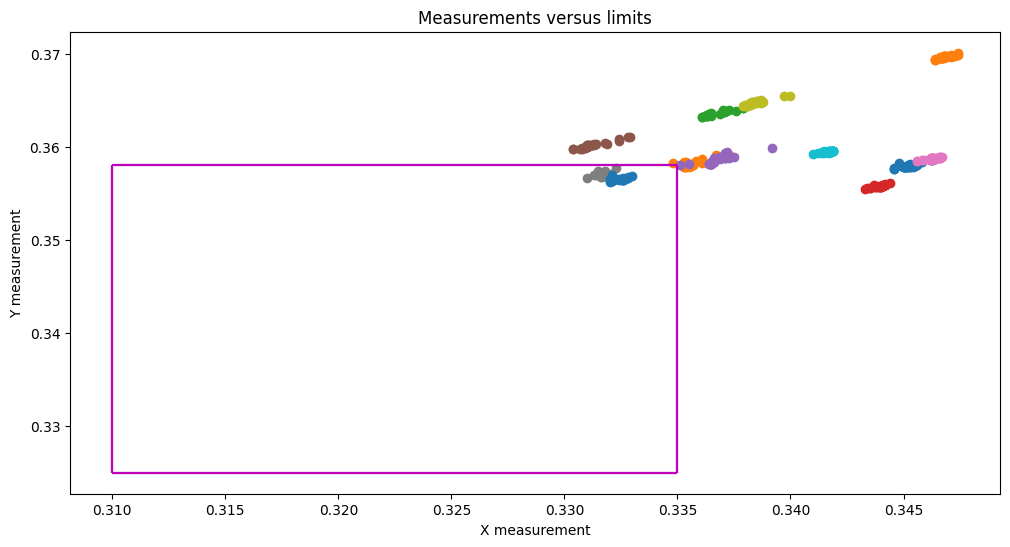

In [8]:
##Data visualization
label = fiber_selection.value
if auto_position.value is False:
    range_mapping = [0.05 - 0.0049 * (range_slider_x.value)]
    xrange = [mean_slider_x.value - range_mapping[0], mean_slider_x.value + range_mapping[0]]
    yrange = [mean_slider_y.value - range_mapping[0], mean_slider_y.value + range_mapping[0]]
else:
    range_mapping = None; xrange = None; yrange = None
display(HBox([fiber_selection, auto_position, mean_slider_x, mean_slider_y]))
display(HBox([range_slider_x, range_slider_y]))
_ = plot_simple_limits(DATA_format, glob.nests_number, xrange=xrange, yrange=yrange, limit_filter=None, fiber_filter=label)

In [ ]:
##Data export
name_pdf = glob.tooling + "_axis_visualization_" + get_date() + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output/reports"), name_pdf)
    _ = plot_to_pdf(DATA_format, name_pdf, plot="Axis")
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Analysis data and visualizations exported inside:
c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output\reports
